# Example integrate Econml and Dowhy using DGP

In [75]:
import dowhy
from dowhy import CausalModel
## Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Helper imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns

## Generate data

We use the following DGP:

\begin{align}
T \sim & \text{Bernoulli}\left(f(W)\right), &\; f(W)=\sigma(\langle W, \beta\rangle + \eta), \;\eta \sim \text{Uniform}(-1, 1)\\
Y = & \theta(X) \cdot T + \langle W, \gamma\rangle + \epsilon, & \; \epsilon \sim \text{Uniform}(-1, 1)\\
W \sim & \text{Normal}(0,\, I_{d_w}) & \\
X \sim & \text{Bernoulli}(0.5)^{d_x}
\end{align}

where $W$ is a matrix of high-dimensional confounders, $\beta$ has high sparsity and $\sigma$ is the sigmoid function.

For this DGP, 
\begin{align}
\theta(x) = -1 + 2 \cdot X_0 + 5 \cdot X_1
\end{align}

In [49]:
import scipy.special

np.random.seed(123)
n=2000 # number of raw samples
d_w=10
d_x=4
support_size = 1
# Outcome support
coefs_Y = np.random.uniform(0, 1, size=d_w)
epsilon_sample = lambda n:np.random.uniform(-1, 1, size=n)
# Treatment support
support_T = np.random.choice(range(d_w), size=support_size, replace=False)
coefs_T = np.random.uniform(0, 1, size=support_size)
eta_sample = lambda n: np.random.uniform(-1, 1, size=n) 

# Generate controls, covariates, treatments and outcomes
W = np.random.normal(0, 1, size=(n, d_w))
X = np.random.binomial(1, .5, size=(n, d_x))
# Heterogeneous treatment effects, the first and third feature creates heterogeneity
TE = (-1 + 2 * X[:, 0] + 5 * X[:, 2])
# Define treatment
T_sigmoid=scipy.special.expit(np.dot(W[:,support_T],coefs_T)+eta_sample(n))
T = np.random.binomial(1,T_sigmoid)
# Define the outcome with treatment effect heterogeneity
Y = TE * T + np.dot(W, coefs_Y) + epsilon_sample(n)

# Create dataframe
X_name=['X'+str(i) for i in range(d_x)]
W_name=['W'+str(i) for i in range(d_w)]
data=np.hstack((X,W,T.reshape(-1,1),Y.reshape(-1,1)))
data=pd.DataFrame(data=data,columns=X_name+W_name+['T','Y'])
data.head()

,X0,X1,X2,X3,W0,W1,W2,W3,W4,W5,W6,W7,W8,W9,T,Y
0,1.0,1.0,1.0,1.0,0.126526,-1.301489,2.207427,0.522742,0.465645,0.724915,1.495827,0.746581,-1.100985,-1.410301,1.0,8.801670
1,0.0,1.0,0.0,0.0,-0.747651,-0.984868,-0.748569,0.240367,-1.855637,-1.779455,-2.750224,-0.234158,-0.695981,-1.774134,0.0,-7.211418
2,0.0,0.0,1.0,0.0,2.361601,0.034993,-0.344642,-0.725032,1.039606,-0.241728,-0.112905,-1.660696,0.013539,0.337374,1.0,4.575606
3,0.0,1.0,0.0,1.0,-0.926623,0.275747,0.370852,1.174307,-2.032292,0.582508,-0.721176,-1.702424,0.767641,0.370679,0.0,-2.509878
4,1.0,0.0,1.0,0.0,2.075459,0.127758,1.799889,1.238366,0.913757,0.466268,0.125040,-0.197651,-0.728035,-0.610313,0.0,3.795635


In [50]:
# get testing data
n_test=100
X_test=np.random.binomial(1, 0.5, size=(n_test, d_x))
data_test = pd.DataFrame(X_test,columns=X_name)
data_test.head()

,X0,X1,X2,X3
0,1,1,0,0
1,1,0,1,0
2,0,1,0,1
3,1,0,1,0
4,1,0,1,0


# Create causal model

In [51]:
# Create a causal model from the data
model = CausalModel(
    data=data,
    treatment='T',
    outcome='Y',
    common_causes=W_name,
    effect_modifiers=X_name)

INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['T'] on outcome ['Y']


INFO:dowhy.causal_graph:Using Matplotlib for plotting


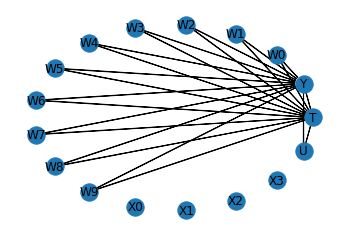

In [52]:
model.view_model()

# Identify causal effect

In [53]:
identified_estimand= model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['W5', 'W9', 'W3', 'W0', 'U', 'W2', 'W6', 'W4', 'W8', 'W7', 'W1']


WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                                
────(Expectation(Y|W5,W9,W3,W0,W2,W6,W4,W8,W7,W1))
d[T]                                              
Estimand assumption 1, Unconfoundedness: If U→{T} and U→Y then P(Y|T,W5,W9,W3,W0,W2,W6,W4,W8,W7,W1,U) = P(Y|T,W5,W9,W3,W0,W2,W6,W4,W8,W7,W1)
### Estimand : 2
Estimand name: iv
No such variable found!



# Estimate CATE using EconML
## Train estimator

In [54]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.LinearDMLCateEstimator",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = data_test,  
                                 confidence_intervals=True,
                                method_params={"init_params":{'model_y':RandomForestRegressor(),
                                                              'model_t': RandomForestClassifier(min_samples_leaf=10),
                                                              'discrete_treatment':True, 
                                                              'linear_first_stages':False,
                                                              'n_splits':6},
                                               "fit_params":{'inference':'statsmodels'}})
print(dml_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: Y~T+W5+W9+W3+W0+W2+W6+W4+W8+W7+W1


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d                                                
────(Expectation(Y|W5,W9,W3,W0,W2,W6,W4,W8,W7,W1))
d[T]                                              
Estimand assumption 1, Unconfoundedness: If U→{T} and U→Y then P(Y|T,W5,W9,W3,W0,W2,W6,W4,W8,W7,W1,U) = P(Y|T,W5,W9,W3,W0,W2,W6,W4,W8,W7,W1)
### Estimand : 2
Estimand name: iv
No such variable found!

## Realized estimand
b: Y~T+W5+W9+W3+W0+W2+W6+W4+W8+W7+W1
## Estimate
Value: 2.55356480682307



In [55]:
print("True ATE is", np.mean(TE))

True ATE is 2.5605


## Performance Visualization

In [56]:
pred_te=dml_estimate.cate_estimates
lb=dml_estimate.effect_intervals[0]
ub=dml_estimate.effect_intervals[1]
truth_te=(-1 + 2 * X_test[:, 0] + 5 * X_test[:, 2])

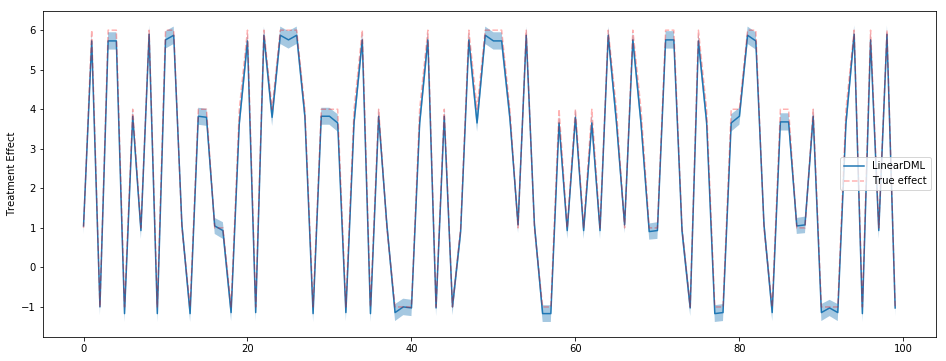

In [57]:
plt.figure(figsize=(16,6))
plt.plot(pred_te, label='LinearDML')
plt.fill_between(range(100),lb.flatten(), ub.flatten(), alpha=.4)
plt.plot(truth_te,'r--', label='True effect',alpha=.3)
plt.ylabel('Treatment Effect')
plt.legend()

## Parameter summary

In [71]:
est=dml_estimate._estimator_object
est.summary(feat_name=['A', 'B', 'C', 'D'])

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
A,2.074,0.116,17.831,0.0,1.883,2.266
B,0.143,0.116,1.231,0.218,-0.048,0.334
C,4.821,0.116,41.591,0.0,4.631,5.012
D,0.026,0.116,0.226,0.822,-0.165,0.218
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
intercept,-1.168,0.129,-9.071,0.0,-1.379,-0.956


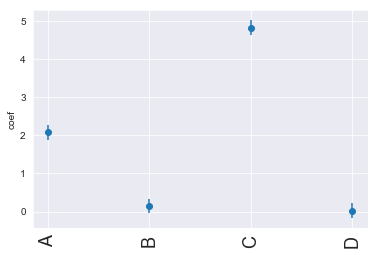

In [60]:
# Getting the confidence intervals of the coefficients of the CATE model
# together with the corresponding feature names.
feat_names = est.cate_feature_names(['A', 'B', 'C', 'D'])
point = est.coef_.flatten()
lower, upper = np.array(est.coef__interval())
lower=lower.flatten()
upper=upper.flatten()
yerr = np.zeros((2, point.shape[0]))
yerr[0, :] = point - lower
yerr[1, :] = upper - point

with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(1,1)
    
    x = np.arange(len(point))
    plt.errorbar(x, point, yerr, fmt='o')
    ax.set_xticks(x)
    ax.set_xticklabels(feat_names, rotation='vertical', fontsize=18)
    ax.set_ylabel('coef')
    plt.show()

## Tree Interpretation of the CATE Model

In [61]:
from econml.cate_interpreter import SingleTreeCateInterpreter

In [62]:
intrp = SingleTreeCateInterpreter(include_model_uncertainty=True, max_depth=2, min_samples_leaf=10)
# We interpret the CATE models behavior on the distribution of heterogeneity features
intrp.interpret(est, X_test)

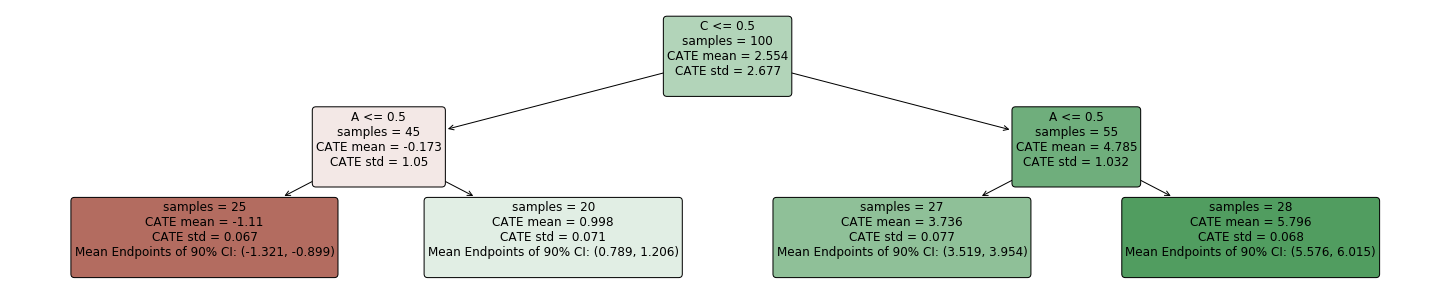

In [63]:
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=['A', 'B', 'C', 'D'], fontsize=12)
plt.show()

## Tree Based Treatment Policy Based on CATE Model

In [64]:
from econml.cate_interpreter import SingleTreePolicyInterpreter

In [65]:
intrp = SingleTreePolicyInterpreter(risk_level=0.05, max_depth=2, min_samples_leaf=1, min_impurity_decrease=.001)
intrp.interpret(est, X_test,sample_treatment_costs=0.2)

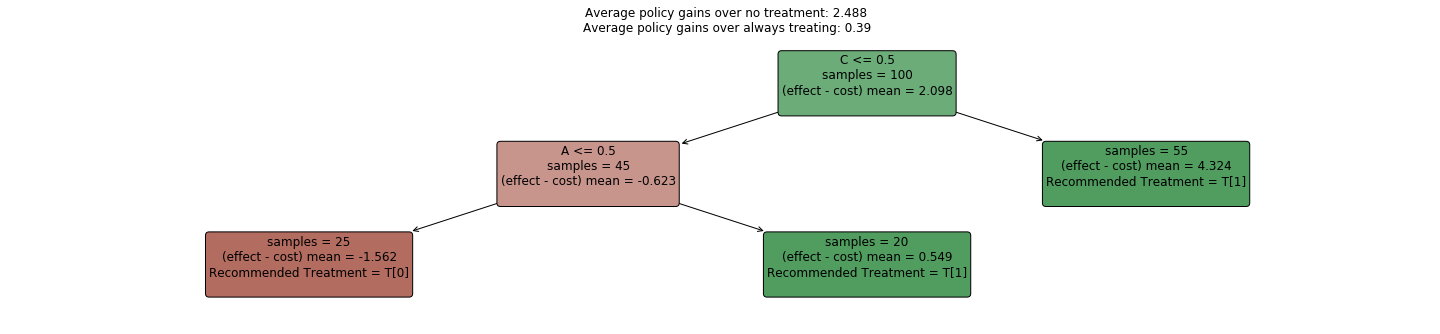

In [66]:
plt.figure(figsize=(25, 5))
intrp.plot(feature_names=['A', 'B', 'C', 'D'], fontsize=12)
plt.show()

# Refute the estimate

In [67]:
# Random common cause
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: Y~T+W5+W9+W3+W0+W2+W6+W4+W8+W7+W1+w_random


Refute: Add a Random Common Cause
Estimated effect:(2.55356480682307,)
New effect:(2.633212923540622,)



In [72]:
# Adding an unobserved common cause variable
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: Y~T+W5+W9+W3+W0+W2+W6+W4+W8+W7+W1


Refute: Add an Unobserved Common Cause
Estimated effect:(2.55356480682307,)
New effect:(2.573917387416744,)



In [73]:
# Replacing treatment with a random (placebo) variable
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: Y~placebo+W5+W9+W3+W0+W2+W6+W4+W8+W7+W1


Refute: Use a Placebo Treatment
Estimated effect:(2.55356480682307,)
New effect:(-0.20245739371453975,)



In [74]:
# Removing a random subset of the data
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8)
print(res_subset)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: Y~T+W5+W9+W3+W0+W2+W6+W4+W8+W7+W1


Refute: Use a subset of data
Estimated effect:(2.55356480682307,)
New effect:(2.476437751237934,)

